In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pylab as pl
from scipy import stats
import math 

%matplotlib inline
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split #All ML libaries
from sklearn import tree 
from sklearn import metrics

# Data Preparation

In [5]:
# Load in the data with `read_csv()`
features = pd.read_csv("features_with_headers.csv",
                     header=0)

tracks = pd.read_csv("tracks_with_headers.csv",
                   header=0)

In [19]:
tracks_sub = tracks[['track_id','track_genre_top','artist_name', 'track_title','track_duration','track_listens']]
tf = tracks_sub.merge(features, left_on='track_id', right_on='track_id', how='inner')

### Remove song sample from train/test set

In [20]:
artist_label="Saylavees"

sample = tf[(tf.artist_name==artist_label)]
sample = sample.iloc[:, 4:523]

modelData = tf[(tf.artist_name!=artist_label)]
modelData.dropna()

genre_label = 'Rock'
genre = modelData[(modelData.track_genre_top==genre_label)]
genre = genre.dropna()

print(tf.shape)
print(sample.shape)
print(modelData.shape)

(106573, 524)
(8, 519)
(106565, 524)


### Remove Outliers

In [21]:
genre_o = genre.copy()
genre_o = genre_o.iloc[:, 4:523] 

z = np.abs(stats.zscore(genre_o))

# Find values causing zscore errors
zdf = pd.DataFrame(z, columns=genre_o.columns.values)
zdf.head(5)
invalid = zdf.isnull().any()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #display(invalid)
    
#Remove columns causing the issues
drop_col = ["chroma_stft_max_12"] #Rock 

genre_o = genre_o.drop(columns=drop_col)
sample = sample.drop(columns=drop_col)

z = np.abs(stats.zscore(genre_o))
genre_o = genre_o[(z < 3).all(axis=1)]

C:\Users\jgorsett\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


### Create popularity feature and data frames for the model

In [22]:
target = genre_o.track_listens

genre_p = genre_o.copy()
genre_p = genre_p.assign(popularity=pd.qcut(target, 3, labels=["low", "med", "high"]))
genre_p.popularity = genre_p.popularity.replace(to_replace=["low","med", "high"], value=[0,0,1])

popular = genre_p.track_listens[genre_p.popularity==1].aggregate('count')
notpopular = genre_p.track_listens[genre_p.popularity==0].aggregate('count')

print(popular)
print(notpopular)

pop_data = genre_p.drop(columns=['track_listens','popularity'])
pop_target = genre_p.popularity

# Get actual popularity for sample
min_track_listens = genre_p.track_listens[genre_p.popularity==1].aggregate('min')
sample_target = np.where(sample['track_listens']<min_track_listens, 0, 1)
sample_data = sample.drop(columns=['track_listens'])

1362
2724


## Exploratory Visualizations

In [60]:
all_tracks = tf.copy()
all_tracks = all_tracks.dropna()
all_tracks = all_tracks.iloc[:, 4:523] 

all_tracks_o = all_tracks.copy()
z = np.abs(stats.zscore(all_tracks_o))
z = np.abs(stats.zscore(all_tracks_o))
all_tracks_o = all_tracks_o[(z < 3).all(axis=1)]
lg_all = np.log(all_tracks_o.track_listens)
lg_genre = np.log(genre_o.track_listens)

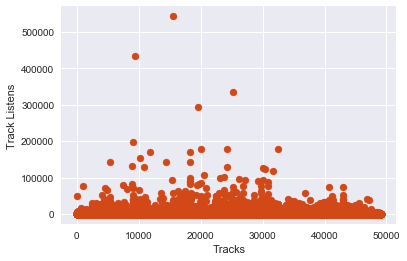

In [61]:
ax = plt.axes()
x = range(0, all_tracks.track_listens.count())
ax.scatter(x, all_tracks.track_listens, color="#D34817")
ax.set(xlabel='Tracks', ylabel='Track Listens');

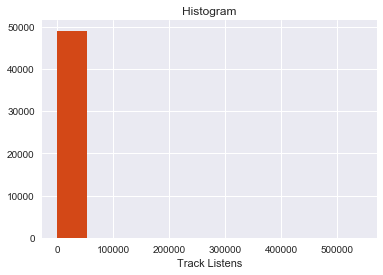

In [62]:
plt.xlabel('Count')
plt.xlabel('Track Listens')
plt.title('Histogram')
all_tracks.track_listens.hist(color="#D34817", bins=10)

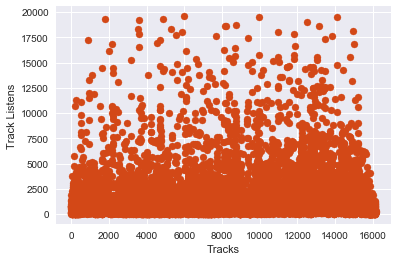

In [63]:
ax = plt.axes()
x = range(0, all_tracks_o.track_listens.count())
ax.scatter(x, all_tracks_o.track_listens, color="#D34817")
ax.set(xlabel='Tracks', ylabel='Track Listens');

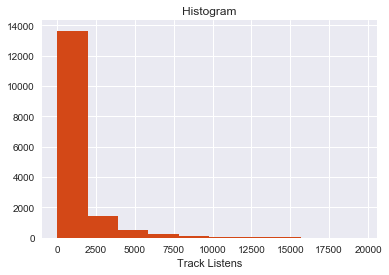

In [64]:
plt.xlabel('Count')
plt.xlabel('Track Listens')
plt.title('Histogram')
all_tracks_o.track_listens.hist(color="#D34817", bins=10)

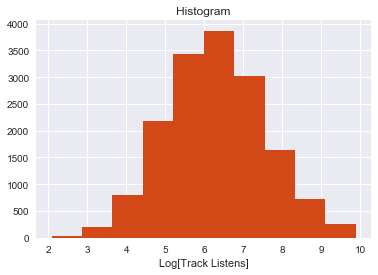

In [65]:
plt.xlabel('Count')
plt.xlabel('Log[Track Listens]')
plt.title('Histogram')
lg_all.hist(color="#D34817", bins=10)

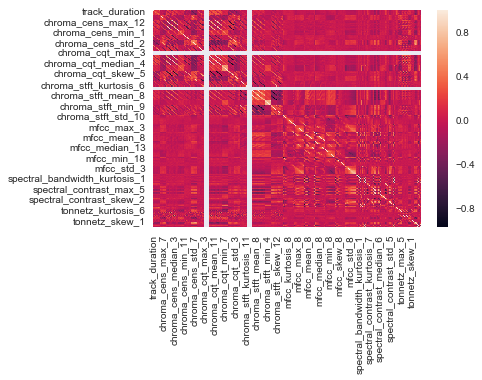

In [66]:
import seaborn as sns
corr = genre_o.corr()
sns.heatmap(corr)#, 
            #xticklabels=corr.columns.values,
           # yticklabels=corr.columns.values)

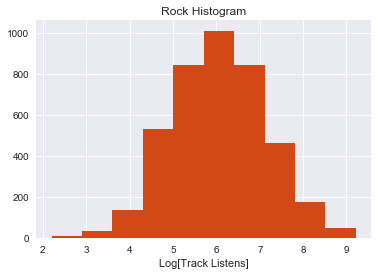

In [67]:
plt.xlabel('Count')
plt.xlabel('Log[Track Listens]')
plt.title(genre_label + ' Histogram')
lg_genre.hist(color="#D34817", bins=10)

[Text(0,0.5,'Track Listens'), Text(0.5,0,'Tracks')]

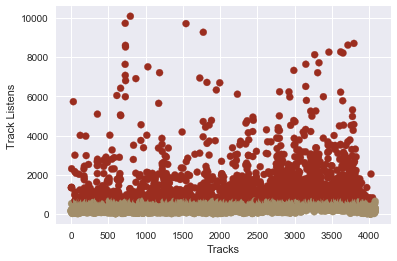

In [68]:
ax = plt.axes()
x = range(0, genre_p.track_listens.count())
pop_color = genre_p.popularity.replace([0,1],["#A28E6A", "#9B2D1F"])
ax.scatter(x, genre_p.track_listens, color=pop_color)
ax.set(xlabel='Tracks', ylabel='Track Listens')

## PCA

In [69]:
scaler = StandardScaler()
scaler.fit(pop_data)
X_scaled = scaler.transform(pop_data)

In [72]:
from sklearn.decomposition import PCA

explained_var_pca = []
for i in range(1, len(pop_data.columns.values)):  
    pca = PCA(n_components=i)
    pca.fit(X_scaled)
    explained_var_pca.append(pca.explained_variance_ratio_.sum())

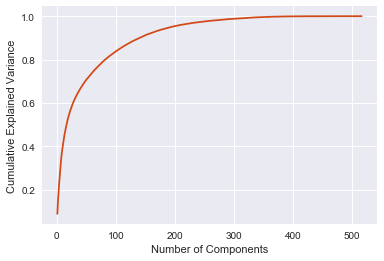

In [73]:
plt.plot(np.arange(1,len(pop_data.columns.values)), explained_var_pca, color="#D34817")
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.show()

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=350)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_.sum())
x_pc = pca.fit_transform(X_scaled)[:,:350]

0.9961773318725651


## Undersampling

In [78]:
pop_data_imbalanced = genre_p.drop(columns=['track_listens'])
pop_target_imbalanced = genre_p.popularity

In [79]:
count_class_0, count_class_1 = pop_data.popularity.value_counts()

# Divide by class
df_class_0 = pop_data_imbalanced[pop_data_imbalanced['popularity'] == 0]
df_class_1 = pop_data_imbalanced[pop_data_imbalanced['popularity'] == 1]

Random under-sampling:
1    1362
0    1362
Name: popularity, dtype: int64


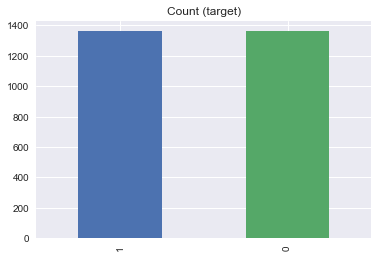

In [80]:
df_class_0_under = df_class_0.sample(count_class_1, random_state=2018)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.popularity.value_counts())

df_test_under.popularity.value_counts().plot(kind='bar', title='Count (target)');

In [81]:
pop_data_under = df_test_under.drop(columns=['popularity'])
pop_target_under = df_test_under.popularity
print(pop_data_under.shape)
print(pop_target_under.shape)

(2724, 517)
(2724,)


## Oversampling

In [82]:
pop_data_imbalanced = genre_p.drop(columns=['track_listens'])
pop_target_imbalanced = genre_p.popularity

In [83]:
count_class_0, count_class_1 = pop_data.popularity.value_counts()

# Divide by class
df_class_0 = pop_data_imbalanced[pop_data_imbalanced['popularity'] == 0]
df_class_1 = pop_data_imbalanced[pop_data_imbalanced['popularity'] == 1]

Random over-sampling:
1    2724
0    2724
Name: popularity, dtype: int64


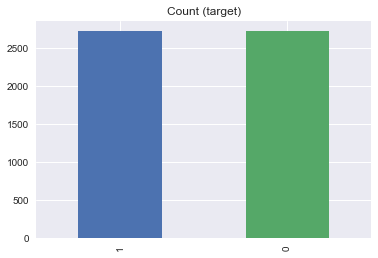

In [84]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=2018)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.popularity.value_counts())

df_test_over.popularity.value_counts().plot(kind='bar', title='Count (target)');

In [85]:
pop_data_over = df_test_over.drop(columns=['popularity'])
pop_target_over = df_test_over.popularity
print(pop_data.shape)
print(pop_target.shape)

(4086, 518)
(4086,)


# SVM

In [86]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler  

In [87]:
X_train, X_test, y_train, y_test = train_test_split(pop_data, pop_target, test_size=0.2, random_state=2018, shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(x_pc, pop_target, test_size=0.2, random_state=2018, shuffle=True)

In [88]:
print(X_train.shape)
print(X_test.shape)

(3268, 518)
(818, 518)


In [89]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [90]:
svmc = svm.SVC(kernel='rbf', C=1000, probability=True, random_state=2018)
svmc = svmc.fit(X_train, y_train)

In [91]:
pred_test = svmc.predict(X_test)
pred_test_prob = svmc.predict_proba(X_test)

In [92]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

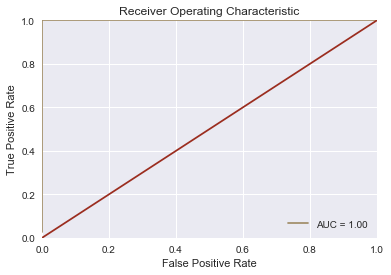

In [93]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '#A28E6A', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'#9B2D1F')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [94]:
print('AUC', metrics.roc_auc_score(y_test, pred_test_prob[:,1]))

AUC 1.0


In [95]:
print('Overall Accuracy', metrics.accuracy_score(y_test, pred_test))

Overall Accuracy 1.0


In [96]:
confmat = metrics.confusion_matrix(y_test, pred_test)

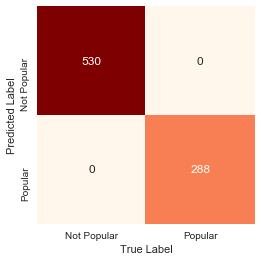

In [97]:
sns.heatmap(confmat.T, square=True, annot=True, fmt='d', cbar=False, cmap="OrRd",
            xticklabels=['Not Popular','Popular'], yticklabels=['Not Popular','Popular'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');